## Gene predictions

This notebook predicts the gene expressions at various points in time.

In [51]:
# Importing libraries
import jax
import gpjax as gpx
import jax.numpy as jnp
import optax as ox
import jax.random as jr

import sys
import os
abs_path = os.path.abspath('../src')
sys.path.append(abs_path)
from p53_data import JAXP53_Data, dataset_3d, generate_test_times
from kernels import latent_kernel
from custom_gps import p53_posterior
from plotter import plot_gp


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(42)

plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)

# Check if LaTeX is in notebook path
if os.environ.get("PATH") is not None:
    if "TeX" not in os.environ["PATH"]:
        os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

cols = rcParams["axes.prop_cycle"].by_key()["color"]

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
# Gene predictions only uses Kxx kernel
import tensorflow_probability.substrates.jax.bijectors as tfb
from dataclasses import dataclass
from gpjax.base import param_field
from jaxtyping import Float
from gpjax.typing import (
    Array,
    ScalarFloat,
)
from jaxtyping import Int

@dataclass
class kxx(gpx.kernels.AbstractKernel):
    initial_sensitivities = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64)

    true_s: Float[Array, "1 5"] = param_field(
        initial_sensitivities,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_sensitivities"},
        trainable=True,
    )

    # Degradation rates of the genes
    initial_decays = jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64)

    true_d: Float[Array, "1 5"] = param_field(
        initial_decays,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_degradations"},
        trainable=True,
    )

    # Lengthscale constrained to be between 0.5 and 3.5
    l_bijector = tfb.Sigmoid(low=0.5, high=3.5)

    initial_lengthscale = jnp.array(2.5, dtype=jnp.float64)

    l: Float[Array, " O"] = param_field(
        initial_lengthscale, bijector=l_bijector, metadata={"name": "lengthscale"}
    )

    def __call__(self, x: Float[Array, " D"], y: Float[Array, " D"]) -> ScalarFloat:
        """
        Compute Kxx kernel (for gene expression predictions)
        """

        # Get gene indices
        j = x[1].astype(int)
        k = y[1].astype(int)

        # Extract data
        x = x[0]
        y = y[0]

        # Equation 5
        # Equation 5

        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, y, x) + self.h(j, k, x, y)

        kxx = mult * second_term

        return kxx.squeeze()
    
    def h(self, j: Int[Array, " O"], k: Int[Array, " O"], x, y):

        dist = y - x
        
        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k] * dist)

        first_erf_terms = jax.scipy.special.erf(
            (dist / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(x / self.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k] * y + self.true_d[j] * x))

        second_erf_terms = jax.scipy.special.erf(
            (y / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        return result

    def gamma(self, k: Int[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) / 2

In [66]:
def clean_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

In [74]:
def generate_test_times_xpr(t=80):
    times = jnp.linspace(0, 13, t)
    gene_indices = jnp.repeat(1, t)
    testing_times = jnp.stack((times, gene_indices, jnp.repeat(1, t)), axis=-1)
    return testing_times

In [67]:
p53_data = JAXP53_Data(replicate=0, data_dir='../data')
training_times, gene_expressions, variances = dataset_3d(p53_data)

In [92]:
p53_data.gene_expressions[:, 0]

Array([[0.21770547, 0.98287555, 2.85188244, 2.74521598, 2.6086432 ,
        1.47332117, 1.52914597]], dtype=float64)

In [95]:
gene_expressions[:7]

Array([[0.21770547],
       [0.98287555],
       [2.85188244],
       [2.74521598],
       [2.6086432 ],
       [1.47332117],
       [1.52914597]], dtype=float64)

In [96]:
training_times[:7]

Array([[ 0.,  0.,  1.],
       [ 2.,  0.,  1.],
       [ 4.,  0.,  1.],
       [ 6.,  0.,  1.],
       [ 8.,  0.,  1.],
       [10.,  0.,  1.],
       [12.,  0.,  1.]], dtype=float64)

In [100]:
# Get training data for 1st gene
index = (35 // 5) * 1
gene_1_times = training_times[:index]
gene_1_expressions = gene_expressions[:index]

In [101]:
D = gpx.Dataset(gene_1_times, gene_1_expressions)

xtest = generate_test_times_xpr(t=80)

In [108]:
meanf = gpx.mean_functions.Zero()
#meanf = latent_mean()
#kernel = latent_kernel()
kernel = kxx()

# Define prior
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [109]:
# Constructing the posterior
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

In [110]:
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=D)

Array(11.04899887, dtype=float64)

In [111]:
opt_posterior, history = gpx.fit(model=posterior, objective=negative_mll, train_data=D,optim=ox.adam(0.01), key=key, num_iters=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Running: 100%|██████████| 100/100 [00:01<00:00, 96.56it/s, Value=8.54]


In [112]:
latent_dist = opt_posterior.predict(xtest, train_data=D)

predictive_mean = latent_dist.mean()
predictive_std = latent_dist.stddev()

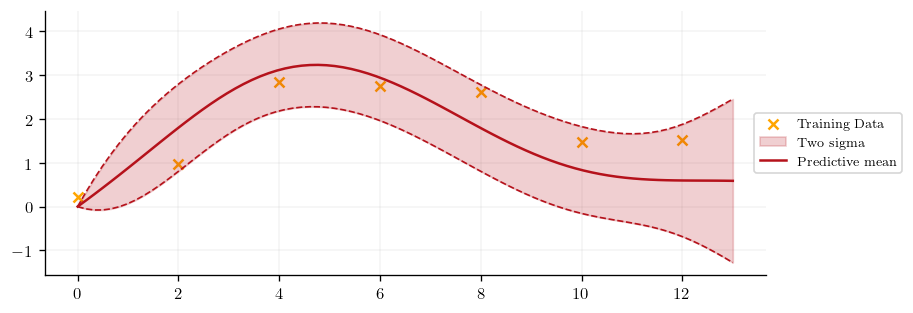

In [114]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.scatter(p53_data.timepoints, p53_data.gene_expressions[:, 0], color="orange", label="Training Data")
ax.fill_between(
    xtest[:,0],
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest[:,0],
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest[:,0],
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)


ax.plot(xtest[:,0], predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))